# Trabajo Semanal 5
### Joaquin Ezequiel Alvarez Olmedo

El trabajo semanal 5 consiste en diseñar un filtro en base a la siguiente plantilla:

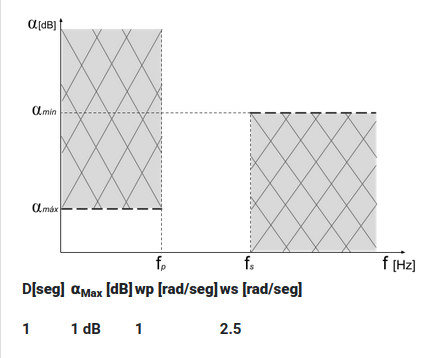

Tendremos que emplear aproximación Bessel para cumplir con el retardo deseado. Desarrollamos los polinomios de Bessel de orden 2, 3 y 4:

$ T(S) = \frac{B_0(S)}{B_n(S)} = \frac{1}{\sinh + \cosh} $

Obtenemos $ \coth = \frac{\sinh}{\cosh} $ ya que es la forma mas fácil de calcular y visualizar $ \sinh $ y $ \cosh $

$ n = 2 $: $ \frac{1}{S} + \frac{S}{3} = \frac{S^{2} + 3}{3S} $

$ T_2(S) = \frac{3}{S^{2} + 3S + 3} $ es la transferencia de orden 2

$ n = 3 $: $ \frac{1}{S} + \frac{5S}{15 + S^{2}} = \frac{15 + 6S^{2}}{S^{3} + 15S} $

$ T_3(S) = \frac{15}{S^{3} + 6S^{2} + 15S + 15} $ es la transferencia de orden 3

$ n = 4 $: $ \frac{1}{S} + \frac{S^{3} + 35S}{105 + 10S^{2}} = \frac{S^{4} + 45S^{2} + 105}{10S^{3} + 105S} $

$ T_4(S) = \frac{105}{S^{4} + 10S^{3} + 45S^{2} + 105S + 105} $ es la transferencia de orden 4

Ahora hay que identificar cual es el filtro de orden mínimo que cumple con la atenuación requerida. En la bibliografia de la materia podemos encontrar un conjunto de gráficos que nos ayudarán a verificar nuestros diseños. Analizamos el gráfico de atenuación en banda de paso:

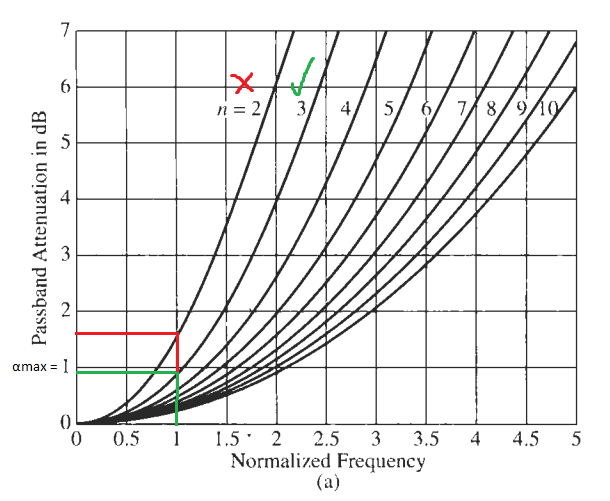

Vemos que para alcanzar un $ \alpha max = 1dB $ a una norma de frecuencia = 1 el filtro de orden 2 no es apropiado para nuestra plantilla pero el de orden 3 si cumple, por lo tanto elegimos $ T_3(S) $.

El delay para un Bessel de orden 3 es el siguiente:

$ D_3(w) = \frac{6w^{4} + 45w^{2} + 225}{w^{6} + 6w^{4} + 45w^{2} + 225} $

Se pide analizar $ D_3(2.5) $ y el error respecto de $ D_3(0) $:

$ D_3(0) = \frac{225}{225} = 1 $

$ D_3(2.5) = \frac{6(2.5)^{4} + 45(2.5)^{2} + 225}{(2.5)^{6} + 6(2.5)^{4} + 45(2.5)^{2} + 225} = \frac{740.62}{984.76} = 0.752 $

$ \epsilon = \frac{D_3(0) - D_3(2)}{D_3(0)} * 100 = 24.79 $%

Verifiquemos con la tabla de delay error:

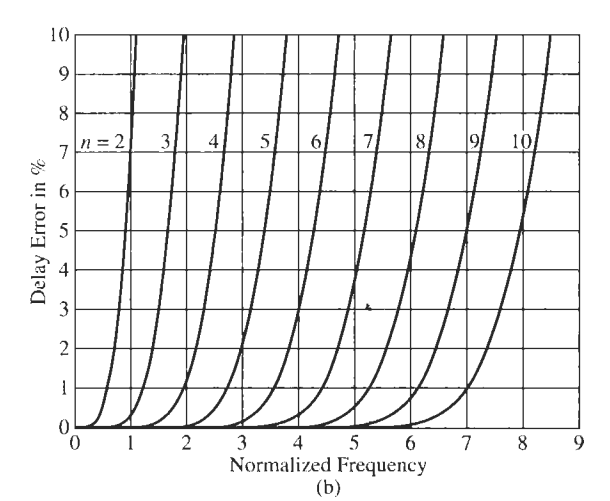

Desafortunadamente la tabla que ofrece el Schaumann solo alcanza a graficar valores de hasta 10% de error y no es suficiente para comprobar los calculos. Podemos revisar la tabla de delay normalizado para verificar el valor obtenido de $ D_3(2.5) = 0.752 $:

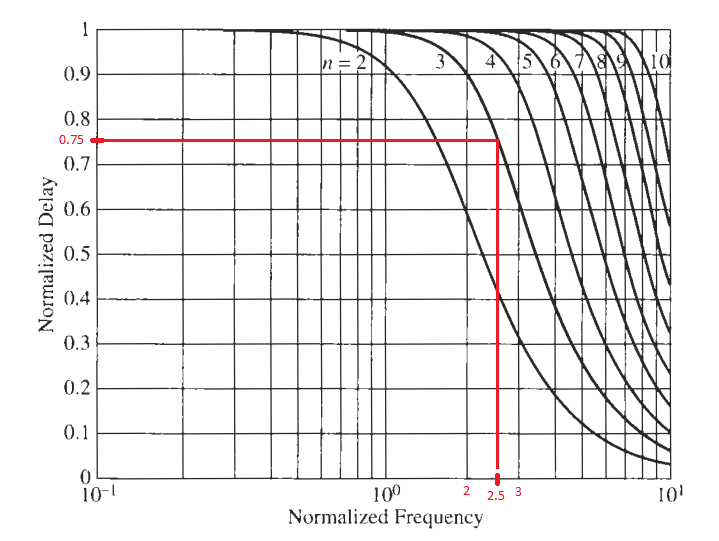

Si lo calculado coincide con el gráfico, damos fe que el cálculo del error también es correcto. 

Pasamos a simular la transferencia. No se pide ningun alfa minimo en particular por lo tanto determinamos uno arbitrario, después de todo si utilizamos un Bessel entonces no nos preocupa mucho lo que suceda con el módulo. A su vez con el siguiente programa podremos contemplar como responde el filtro al retardo de grupo:

#### Bessel_ord_3_rip_1_att_40

<IPython.core.display.Math object>

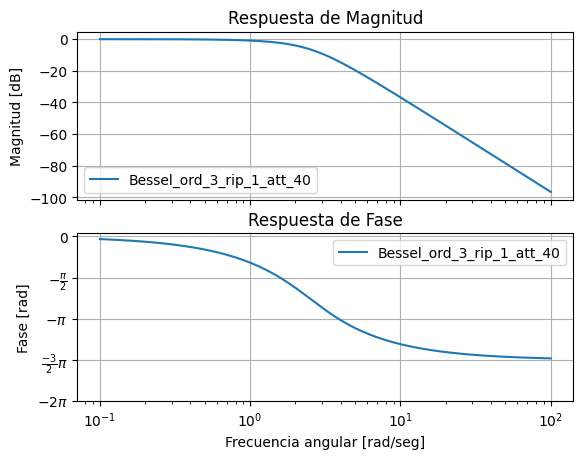

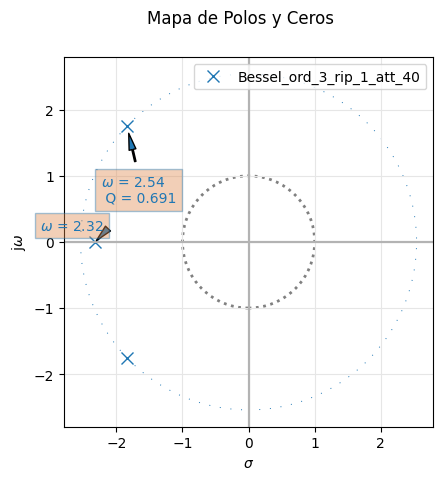

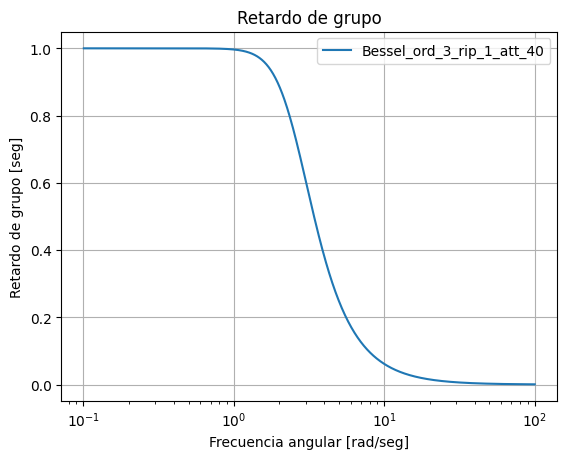

In [2]:
#%% Importamos librerias
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
from pytc2.sistemas_lineales import analyze_sys, pretty_print_bicuad_omegayq, tf2sos_analog, pretty_print_SOS
from pytc2.general import print_subtitle


#%% Esta funcion elige con que aproximacion diseñamos el filtro dependiendo lo que le indiquemos
def sim_aprox(aproxs, orders2analyze, ripple, attenuation):

    all_sys = []
    filter_names = []

    for (this_aprox, this_order, this_ripple, this_att) in zip(aproxs, orders2analyze, ripple, attenuation):

        if this_aprox == 'Butterworth':

            z,p,k = sig.buttap(this_order)

            eps = np.sqrt( 10**(this_ripple/10) - 1 )
            num, den = sig.zpk2tf(z,p,k)
            num, den = sig.lp2lp(num, den, eps**(-1/this_order))

            z,p,k = sig.tf2zpk(num, den)

        elif this_aprox == 'Chebyshev1':

            z,p,k = sig.cheb1ap(this_order, this_ripple)

        elif this_aprox == 'Chebyshev2':

            z,p,k = sig.cheb2ap(this_order, this_att)

        elif this_aprox == 'Bessel':

            z,p,k = sig.besselap(this_order, norm='delay')

        elif this_aprox == 'Cauer':

            z,p,k = sig.ellipap(this_order, this_ripple, this_att)


        num, den = sig.zpk2tf(z,p,k)

        
        all_sys.append(sig.TransferFunction(num,den))

        this_label = this_aprox + '_ord_' + str(this_order) + '_rip_' + str(this_ripple)+ '_att_' + str(this_att)
        
        print_subtitle(this_label)
        # factorizamos en SOS's
        this_sos = tf2sos_analog(num, den)
        
        pretty_print_SOS(this_sos, mode='omegayq')
        
        filter_names.append(this_label)
        
    # el caracter "_" descarta la salida de la función
    _ = analyze_sys( all_sys, filter_names )

    return( all_sys, filter_names )


#%% Indicamos aproximacion, orden, alfa min y max
#aprox_name = 'Butterworth'
#aprox_name = 'Chebyshev1'
#aprox_name = 'Chebyshev2'
aprox_name = 'Bessel'
#aprox_name = 'Cauer'

# Parametrizamos el orden
orders2analyze = [3]

# Mismo requerimiento de ripple y atenuación
aproxs = [aprox_name] * len(orders2analyze)
ripple = [1] * len(orders2analyze) # Alfa maximo en dB
attenuation = [40] * len(orders2analyze) # Alfa minimo en dB

( all_sys, filter_names ) = sim_aprox(aproxs, orders2analyze, ripple, attenuation)

Ahora proponemos un circuito con el cual crear la transferencia deseada. Utilizamos un Sallen-Key para sintetizar la SOS:

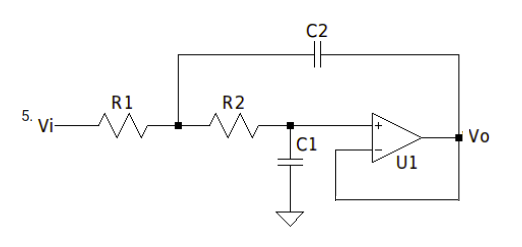

Planteamos las ecuaciones de nodos:

1) $ V_x(\frac{1}{R_1} + \frac{1}{R_2} + SC_2) - V_i(\frac{1}{R_1}) - V_o(SC_2) - V_y(\frac{1}{R_2}) = 0 $

2) $ V_y(\frac{1}{R_2} + SC_1) - V_x(\frac{1}{R_2}) = 0 $

Deducimos a simle vista que $ V_y = V_o $ y reemplazamos en 2:

$ V_o(\frac{SC_1R_2 + 1}{R_2}) = V_x(\frac{1}{R_2}) $

$ V_x = V_o(SC_1R_2 + 1) $

Reemplazamos las expresiones en 1:

$ V_o * (SC_1R_2 + 1) * (\frac{SC_2R_1R_2 + R_1 + R_2}{R_1R_2}) - V_o(SC_2) - V_o(\frac{1}{R_2}) = V_i(\frac{1}{R_1}) $

$ V_o(\frac{S^{2}C_1R_1R_2^{2} + SC_1R_2(R_1 + R_2) + SC_2R_1R_2 + R_1 + R_2 - SC_2R_1R_2 - R_1}{R_1R_2}) = V_i(\frac{1}{R_1}) $

$ \frac{V_o}{V_i} = \frac{R_2}{S^{2}C_1R_1R_2^{2} + SC_1R_2(R_1 + R_2) + R_2} $

$ T(S) = \frac{\frac{1}{C_1R_1R_2}}{S^{2} + S(\frac{R_1 + R_2}{R_1R_2}) + \frac{1}{C_1R_1R_2}} $

Donde:

$ w_0^{2} = \frac{1}{C_1R_1R_2} $

$ \frac{w_0}{Q} = \frac{R_1 + R_2}{R_1R_2} $

$ K = 1 $

Normalizamos según $ w_0 $ y obtenemos:

$ 1 = \frac{1}{C_1R_1R_2} $

Proponemos R_1 = R_2 = R y C_1 = C_2 = C:

$ C = \frac{1}{R^{2}} $

Por otro lado:

$ \frac{1}{Q} = \frac{R_1 + R_2}{R_1R_2} = \frac{2R}{R^{2}} $

$ R = 2Q $

Normalizamos en impedancia según R:

$ C_1 = C_2 = 1 $, $ R_1 = R_2 = 1 $

Para la sección de orden 1, proponemos inductor en serie y resistencia en derivación:

$ T(S) = \frac{\frac{R}{L}}{S + \frac{R}{L}} $ donde $ w_0 = \frac{R}{L} = 2.322 $

Normalizado en frecuencia y en impedancia obtenemos R = 1 y L = 1.

El filtro estará compuesto por un Sallen-Key y un pasa-bajos de orden 1.